In [1]:
# this notebook contains code for the BIGANTR model
# modified to include variable abrasion

In [2]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# set sed thickness
Hstar = 0.5 # depth decay

In [4]:
# define constants and other parameters
K = 1e-6 # erodibility
beta_0 = 0.00025 # sediment attrition # least abradable
beta_1 = 0.0005 # sediment attrition
beta_2 = 0.00075 # sediment attrition # most abradable
zeta = 0.001 # bedrock abrasion
r = 5. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.5 # fraction of plucked material that becomes coarse

kQs = 0.041 # sed transport coefficient
kxb = 25 # valley width coefficient
Pxb = 1./5. # valley width exponment
kb = 8.3e-8 # channel width coefficient

B_valley = kxb * (x_node**Pxb) # valley width
A = (1./3.) * (x**2)
Q = r * A

dt = 10 # timestep

In [5]:
def BIGANTR(x, dx, 
            K, beta_0, beta_1, beta_2, zeta, 
            gamma, D, phi, Hstar, 
            kQs, I, r, U, 
            B_valley, Q, 
            dt, num_steps = 1):
    
    # set up run duration and start counting time
    run_duration = dt * num_steps
    cum_time = 0.0
    
    # initialize arrays
    etab = np.zeros(len(x)) # bedrock elevation
    etab[:] = np.linspace(1, 0.1, len(x)) # start with slight bedrock slope

    H_0 = (Hstar/3) + np.zeros(len(x))
    H_1 = (Hstar/3) + np.zeros(len(x))
    H_2 = (Hstar/3) + np.zeros(len(x))
    H = H_0 + H_1 + H_2 # alluvium thickness

    eta = etab + H # topography
    
    Qs = np.zeros(len(x))
    
    f_0 = np.zeros(len(x))
    f_0[:] = (1./3.)
    Qs_0 = np.zeros(len(x))
    Eh_0 = np.zeros(len(x))
    
    f_1 = np.zeros(len(x))
    f_1[:] = (1./3.)
    Qs_1 = np.zeros(len(x))
    Eh_1 = np.zeros(len(x))
    
    f_2 = np.zeros(len(x))
    f_2[:] = (1./3.)
    Qs_2 = np.zeros(len(x))
    Eh_2 = np.zeros(len(x))
    
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    
    ql = np.zeros(len(x)) # lateral sediment supply
    ql_0 = np.zeros(len(x)) # lateral sediment supply
    ql_1 = np.zeros(len(x)) # lateral sediment supply
    ql_2 = np.zeros(len(x)) # lateral sediment supply
    
    # set boundary conditions
    H[-1] = 0
    E[-1] = U
    Qs[0] = 0
    
    # track time
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kQs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * I
        Eb_a[:-1] = zeta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql_0[:-1] = (((Eb[:-1]/3) * gamma)/beta_0) * (1 - np.exp(-beta_0 * x[1:]/3))
        ql_1[:-1] = (((Eb[:-1]/3) * gamma)/beta_1) * (1 - np.exp(-beta_1 * x[1:]/3))
        ql_2[:-1] = (((Eb[:-1]/3) * gamma)/beta_2) * (1 - np.exp(-beta_2 * x[1:]/3))
        
        # calc Qs_0 (f_0 * Qs)
        Qs_0[1:] = f_0[1:] * Qs[1:]
        Qs_1[1:] = f_1[1:] * Qs[1:]
        Qs_2[1:] = f_2[1:] * Qs[1:]
        
        # calc atr_0 (Qs_0 * beta_0)
        atr_0 = Qs_0 * beta_0
        atr_1 = Qs_1 * beta_1
        atr_2 = Qs_2 * beta_2
        atr = atr_0 + atr_1 + atr_2
        
        # calc sediment erosion rate Eh_0 (use Qs_0, atr_0, Eb_p/3, and ql_0)
        Eh_0[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs_0)/dx + atr_0[1:] - ((Eb_p[:-1]/3)*gamma) - ql_0[:-1])
        Eh_1[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs_1)/dx + atr_1[1:] - ((Eb_p[:-1]/3)*gamma) - ql_1[:-1])
        Eh_2[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs_2)/dx + atr_2[1:] - ((Eb_p[:-1]/3)*gamma) - ql_2[:-1])
        Eh = Eh_0 + Eh_1 + Eh_2
        
        # calc H_0 (Eh_0 * dt)
        H_0[:-1] -= Eh_0[:-1] * dt
        H_1[:-1] -= Eh_1[:-1] * dt
        H_2[:-1] -= Eh_2[:-1] * dt
        
        # calc H (H_0 + H_1 + H_2)
        H = H_0 + H_1 + H_2
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update f_0 (H_0/H)
        f_0[1:] = H_0[:-1]/H[:-1] # 1 - (atr_0[1:] / atr[1:]) # first cell of f_0 should be constant at 1/3 ratio of total H
        f_1[1:] = H_1[:-1]/H[:-1] # 1 - (atr_1[1:] / atr[1:])
        f_2[1:] = H_2[:-1]/H[:-1] # 1 - (atr_2[1:] / atr[1:])
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
    
    # check total time (yrs)
    print(cum_time)
        
    return (dt, S, alpha, Qs, Eb_p, Eb_a, Eb, ql_0, ql_1, ql_2, f_0, f_1, f_2, 
            Qs_0, Qs_1, Qs_2, atr_0, atr_1, atr_2, Eh_0, Eh_1, Eh_2, Eh, E, etab, H, H_0, H_1, H_2, eta)

In [6]:
#now write a test
num_steps = 5000000 # 3000000

default_run = [x, dx, 
            K, beta_0, beta_1, beta_2, zeta, 
            gamma, D, phi, Hstar,
            kQs, I, r, U,
            B_valley, Q,
            dt, num_steps]

# and run it
(dt, S, alpha, Qs, Eb_p, Eb_a, Eb, ql_0, ql_1, ql_2, f_0, f_1, f_2, Qs_0, Qs_1, Qs_2, 
 atr_0, atr_1, atr_2, Eh_0, Eh_1, Eh_2, Eh, E, etab, H, H_0, H_1, H_2, eta) = BIGANTR(*default_run)

50000000.0


In [7]:
# check that we have reached steady state condition by printing out the bedrock erosion rate
Eb

array([9.99998257e-05, 1.00000024e-04, 9.99999999e-05, 9.99999996e-05,
       9.99999997e-05, 9.99999998e-05, 9.99999999e-05, 9.99999999e-05,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
      

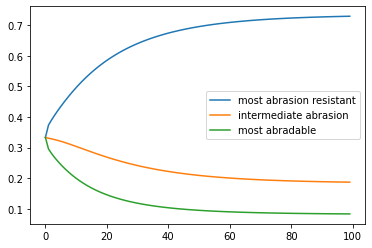

In [8]:
plt.plot(f_0, label = "most abrasion resistant")
plt.plot(f_1, label = "intermediate abrasion")
plt.plot(f_2, label = "most abradable")
plt.legend()

In [9]:
f_0

array([0.33333333, 0.37364799, 0.3906053 , 0.406052  , 0.42058911,
       0.43450278, 0.44787476, 0.46072984, 0.47307746, 0.48492402,
       0.49627668, 0.50714444, 0.51753819, 0.52747047, 0.53695515,
       0.54600707, 0.55464177, 0.56287518, 0.57072343, 0.57820263,
       0.58532877, 0.59211756, 0.59858437, 0.60474414, 0.61061134,
       0.61619992, 0.6215233 , 0.62659438, 0.63142548, 0.63602839,
       0.64041435, 0.6445941 , 0.64857782, 0.65237522, 0.65599553,
       0.65944751, 0.66273946, 0.66587928, 0.66887446, 0.6717321 ,
       0.67445892, 0.67706131, 0.67954533, 0.68191671, 0.6841809 ,
       0.68634304, 0.68840805, 0.69038055, 0.69226495, 0.69406542,
       0.69578594, 0.69743025, 0.69900194, 0.70050438, 0.7019408 ,
       0.70331426, 0.70462767, 0.70588377, 0.70708521, 0.70823447,
       0.70933393, 0.71038585, 0.71139237, 0.71235553, 0.71327729,
       0.7141595 , 0.71500392, 0.71581223, 0.71658603, 0.71732686,
       0.71803615, 0.71871531, 0.71936564, 0.71998843, 0.72058

In [10]:
f_1

array([0.33333333, 0.33068324, 0.32864592, 0.32629616, 0.32366611,
       0.32078397, 0.31768786, 0.31441751, 0.31101094, 0.30750308,
       0.30392539, 0.30030568, 0.29666831, 0.29303432, 0.28942168,
       0.28584564, 0.28231892, 0.27885205, 0.27545356, 0.2721303 ,
       0.26888761, 0.2657295 , 0.26265891, 0.2596778 , 0.25678732,
       0.25398792, 0.25127951, 0.24866148, 0.24613284, 0.24369229,
       0.24133823, 0.23906888, 0.2368823 , 0.2347764 , 0.23274902,
       0.23079793, 0.22892085, 0.2271155 , 0.22537957, 0.22371079,
       0.22210687, 0.22056559, 0.21908475, 0.21766218, 0.21629579,
       0.2149835 , 0.21372333, 0.2125133 , 0.21135155, 0.21023622,
       0.20916555, 0.20813781, 0.20715135, 0.20620455, 0.20529587,
       0.20442382, 0.20358695, 0.20278387, 0.20201325, 0.2012738 ,
       0.20056428, 0.1998835 , 0.1992303 , 0.19860359, 0.19800231,
       0.19742543, 0.19687198, 0.19634101, 0.19583161, 0.19534293,
       0.19487411, 0.19442437, 0.19399293, 0.19357904, 0.19318

In [11]:
f_2

array([0.33333333, 0.29566877, 0.28074878, 0.26765184, 0.25574479,
       0.24471325, 0.23443739, 0.22485265, 0.2159116 , 0.2075729 ,
       0.19979793, 0.19254987, 0.18579349, 0.17949521, 0.17362317,
       0.16814728, 0.1630393 , 0.15827277, 0.15382301, 0.14966707,
       0.14578363, 0.14215294, 0.13875671, 0.13557806, 0.13260134,
       0.12981216, 0.12719719, 0.12474414, 0.12244168, 0.12027933,
       0.11824742, 0.11633702, 0.11453988, 0.11284837, 0.11125544,
       0.10975456, 0.10833969, 0.10700522, 0.10574596, 0.10455712,
       0.10343421, 0.10237309, 0.10136992, 0.1004211 , 0.09952332,
       0.09867345, 0.09786863, 0.09710615, 0.0963835 , 0.09569835,
       0.09504851, 0.09443194, 0.09384672, 0.09329107, 0.09276333,
       0.09226192, 0.09178539, 0.09133236, 0.09090154, 0.09049173,
       0.09010179, 0.08973066, 0.08937733, 0.08904087, 0.0887204 ,
       0.08841507, 0.0881241 , 0.08784676, 0.08758235, 0.08733022,
       0.08708974, 0.08686032, 0.08664143, 0.08643253, 0.08623

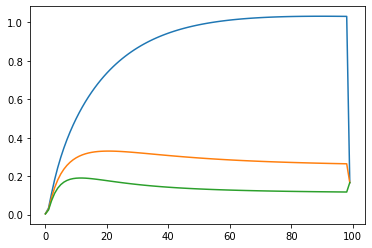

In [12]:
plt.plot(H_0)
plt.plot(H_1)
plt.plot(H_2)

In [13]:
H_0

array([0.00484836, 0.03367741, 0.11051484, 0.18248935, 0.24432436,
       0.29834742, 0.34641002, 0.38977764, 0.429325  , 0.46567588,
       0.49929003, 0.53051697, 0.55963003, 0.58684845, 0.61235213,
       0.63629171, 0.65879551, 0.67997456, 0.69992619, 0.71873669,
       0.73648329, 0.75323566, 0.76905713, 0.78400551, 0.79813392,
       0.81149131, 0.82412294, 0.83607084, 0.84737405, 0.85806899,
       0.86818962, 0.87776773, 0.88683308, 0.89541354, 0.9035353 ,
       0.91122294, 0.91849957, 0.92538693, 0.93190549, 0.93807454,
       0.94391225, 0.94943577, 0.95466126, 0.95960401, 0.96427843,
       0.96869816, 0.97287607, 0.97682435, 0.98055453, 0.98407751,
       0.98740362, 0.99054264, 0.99350384, 0.996296  , 0.99892743,
       1.00140604, 1.0037393 , 1.00593433, 1.00799786, 1.00993629,
       1.0117557 , 1.01346187, 1.01506026, 1.0165561 , 1.01795434,
       1.01925968, 1.02047661, 1.02160937, 1.02266203, 1.02363843,
       1.02454224, 1.02537696, 1.0261459 , 1.02685223, 1.02749

In [14]:
f_0+f_1+f_2

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

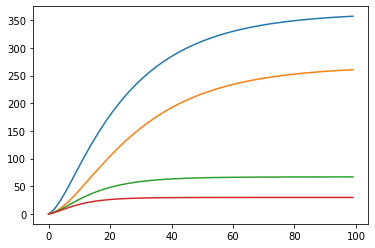

In [15]:
plt.plot(Qs)
plt.plot(Qs_0)
plt.plot(Qs_1)
plt.plot(Qs_2)

In [17]:
Qs_0

array([  0.        ,   1.48170221,   3.77900066,   6.88301613,
        10.7001943 ,  15.11376763,  20.01745646,  25.31744986,
        30.93162644,  36.7883979 ,  42.8255557 ,  48.98920374,
        55.23279399,  61.51626316,  67.80526359,  74.07047949,
        80.28702004,  86.43388122,  92.49346897,  98.45117686,
       104.29501235, 110.01526616, 115.60421993, 121.0558879 ,
       126.36578881, 131.53074449, 136.5487023 , 141.41857858,
       146.14012076, 150.71378601, 155.14063465, 159.42223638,
       163.56058811, 167.558042  , 171.41724235, 175.14107065,
       178.73259748, 182.19504075, 185.53172942, 188.74607199,
       191.84152936, 194.82159139, 197.68975681, 200.44951608,
       203.10433674, 205.65765108, 208.11284577, 210.47325324,
       212.74214455, 214.9227236 , 217.01812251, 219.03139799,
       220.96552861, 222.82341277, 224.60786743, 226.32162728,
       227.96734453, 229.54758898, 231.06484855, 232.52153004,
       233.9199602 , 235.26238698, 236.55098092, 237.78